## Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import math

## Funções Genéricas

### Modelo Genérico

In [12]:
def run_model(model, X_scaled, crossval_results, feature_names=None):
    labels = model.fit_predict(X_scaled)

    silhouette = float(silhouette_score(X_scaled, labels))
    ch_score = float(calinski_harabasz_score(X_scaled, labels))
    db_score = float(davies_bouldin_score(X_scaled, labels))

    crossval_results.append((silhouette, ch_score, db_score))

    # # Salvar centróides se for KMeans
    # if hasattr(model, 'cluster_centers_') and feature_names is not None:
    #     centroids_df = pd.DataFrame(model.cluster_centers_, columns=feature_names)
    #     return labels, crossval_results, centroids_df

    return labels, crossval_results

### PCA

In [13]:
def pca_gen(X_scaled, df, column, title, feature_names=None, return_loadings=False):
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X_scaled)
    df['PC1'] = pca_components[:, 0]
    df['PC2'] = pca_components[:, 1]

    # print(len(title))
    # print(len(column))
    # Preparar os plots
    fig, axs = plt.subplots(1, len(title), figsize=((len(title) * 6), 5))

    if len(title) == 1:
        axs = [axs]
    # PCA scatter plots
    for i in range(len(title)):
        sns.scatterplot(data=df, x='PC1', y='PC2', hue=column[i], ax=axs[i]).set_title(title[i])
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='dbscan', ax=axs[1]).set_title("DBSCAN")
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='agglo', ax=axs[2]).set_title("Agglomerative")

    plt.tight_layout()
    plt.show()

    # Se quiser retornar os pesos (cargas) do PCA
    if return_loadings and feature_names is not None:
        loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)
        explained_var = pca.explained_variance_ratio_
        return loadings_df, explained_var

    return None, None

#### Gráfico de Visualização do PCA

In [14]:
def plot_pca_loadings_barras(loadings_df, component, top_n, title):
    """
    Plota os top_n alimentos com maior influência no componente principal especificado.

    Parâmetros:
    - loadings_df: DataFrame de pesos (output do PCA).
    - component: 'PC1', 'PC2', etc.
    - top_n: número de alimentos mais influentes a mostrar.
    - title: título opcional do gráfico.
    """
    fig, axs = plt.subplots(1, len(component), figsize=((len(component) * 6), 5))

    for i in range(len(component)):
    # Seleciona os valores absolutos mais influentes
        abs_loadings = loadings_df[component[i]].abs().sort_values(ascending=False).head(top_n)
        selected_features = loadings_df.loc[abs_loadings.index, component[i]]


    # Plot
    # plt.figure(figsize=(10, 6))
        sns.barplot(x=selected_features.values,
                    y=selected_features.index, palette="viridis",
                    hue=selected_features.index, ax=axs[i])
        axs[i].set_xlabel(f'Carga no {component[i]}')
        axs[i].set_ylabel('Alimento')
        axs[i].set_title(f'Top {top_n} alimentos mais influentes em {component[i]} de {title}')
    # plt.xlabel(f'Carga no {component}')
    # plt.ylabel('Alimento')
    # plt.title(f'Top {top_n} alimentos mais influentes em {component} de {title}')
    # plt.grid(True)
    plt.tight_layout()
    plt.show()


### Boxplot

In [15]:
def boxplot_gen(df, alimentos, column, title):
    """
    Gera boxplots para cada alimento comparando os clusters.

    Parâmetros:
    - df: DataFrame contendo as colunas de alimentos e a de cluster.
    - alimentos: lista com os nomes das colunas de alimentos.
    - cluster_col: nome da coluna dos rótulos de cluster.
    - title_prefix: prefixo para os títulos dos gráficos.
    """
    # import seaborn as sns
    # import matplotlib.pyplot as plt
    n_rows = len(alimentos)
    n_cols = len(column)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=((n_cols * 6), n_rows * 5), squeeze=False)

    # if len(column) == 1:
    #     axs = [axs]


    for row_idx, alimento in enumerate(alimentos):
        for col_idx, cluster_col in enumerate(column):
            # cluster_col = df[column[i]]
            # print(cluster_col)
            ax = axs[row_idx][col_idx] # if n_cols > 1 else axs[col_idx]
            sns.boxplot(data=df, x=cluster_col, y=alimento, ax=ax, hue=cluster_col, palette='Set2')
            ax.set_title(f'Consumo de {alimento} por cluster ({title[col_idx]})')
            ax.set_xlabel('Cluster')
            ax.set_ylabel(f'{alimento} consumption')
            ax.grid(True)

    plt.tight_layout()
    plt.show()

### Heatmap

In [16]:
# Usar pivot para criar heatmap país x ano com índice
def heatmap_gen(df, alimentos, column, title):
    """
    Gera um heatmap com a média de consumo dos alimentos por cluster.

    Parâmetros:
    - df: DataFrame com dados.
    - alimentos: lista de colunas de alimentos.
    - cluster_col: nome da coluna com os rótulos dos clusters.
    - title: título do gráfico.
    - cmap: colormap do heatmap.
    """
    fig, axs = plt.subplots(1, len(column), figsize=((len(column) * 6), 5), squeeze=False)

    # if len(column) == 1:
    #     axs = [axs]

    for i in range(len(column)):
        ax = axs[0][i]

        # Calcula a média dos alimentos por cluster
        cluster_means = df.groupby(column[i])[alimentos].mean().T

        sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5, ax=ax)
        ax.set_title(f'Média de consumo dos alimentos por cluster ({title[i]})')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Alimento')

    plt.tight_layout()
    plt.show()

### Importância Relativa (Z-score)

In [17]:
# Usar pivot para criar heatmap país x ano com índice
def relative_variation(df, alimentos, column, title):
    """
    Gera um heatmap com a média de consumo dos alimentos por cluster.

    Parâmetros:
    - df: DataFrame com dados.
    - alimentos: lista de colunas de alimentos.
    - cluster_col: nome da coluna com os rótulos dos clusters.
    - title: título do gráfico.
    - cmap: colormap do heatmap.
    """
    fig, axs = plt.subplots(1, len(column), figsize=((len(column) * 6), 5), squeeze=False)

    # if len(column) == 1:
    #     axs = [axs]

    for i in range(len(column)):
        ax = axs[0][i]

        # Calcula a média dos alimentos por cluster
        cluster_means = df.groupby(column[i])[alimentos].mean()

        # Calcula a variação (máximo - mínimo) por alimento
        variation = cluster_means.max() - cluster_means.min()

        # Ordena em ordem decrescente
        variation.sort_values(ascending=False)

        # Gráfico de barras
        sns.barplot(x=variation.values, y=variation.index, hue=variation.index, palette='YlGnBu', ax=ax)
        # sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5, ax=ax)
        ax.set_title(f'Importância relativa dos alimentos\n({title[i]})')
        ax.set_xlabel('Variação entre clusters (μg/kg)')
        ax.set_ylabel('Alimento')

    plt.tight_layout()
    plt.show()



### Histplot

In [18]:
def histplot_gen(df, columns, cols_per_row=4):
    """
    Plota histogramas com KDE das colunas especificadas, organizando as figuras em linhas e colunas.

    Parâmetros:
    - df: DataFrame com os dados.
    - columns: lista com os nomes das colunas a serem plotadas.
    - cols_per_row: número de plots por linha (padrão = 4).
    """
    total = len(columns)
    rows = math.ceil(total / cols_per_row)

    fig, axs = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
    axs = axs.flatten()  # Para iterar facilmente, mesmo que tenha 1 linha só

    sns.set(style="white")

    for idx, col in enumerate(columns):
        sns.histplot(data=df, x=col, kde=True, ax=axs[idx], color="skyblue")
        axs[idx].set_title(col)

    # Desativar os subplots que não foram usados
    for j in range(idx + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


## Carregando dados

In [19]:
df = pd.read_csv("processed_microplastics.csv")
df.head(5)

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,...,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,...,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,...,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,...,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,...,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,...,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      723 non-null    int64  
 1   country                   723 non-null    object 
 2   cheese                    723 non-null    float64
 3   yoghurt                   723 non-null    float64
 4   total_milk                723 non-null    float64
 5   fruits                    723 non-null    float64
 6   refined_grains            723 non-null    float64
 7   whole_grains              723 non-null    float64
 8   nuts_and_seeds            723 non-null    float64
 9   total_processed_meats     723 non-null    float64
 10  unprocessed_red_meats     723 non-null    float64
 11  fish                      723 non-null    float64
 12  shellfish                 723 non-null    float64
 13  eggs                      723 non-null    float64
 14  total_salt

In [21]:
df.describe()

,year,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,2005.113416,6.135622,54.175691,250.655223,198.891339,310.733750,76.090720,12.716421,43.242799,90.326727,40.367154,7.415298,17.184714,6.844069,87.980939,232.405995,81.885598,64.300877,19.261638,1600.614574
std,9.610611,10.437505,77.868834,243.250670,150.271271,138.658231,81.578881,10.827892,39.223624,67.646655,34.835918,13.695479,14.584195,1.806978,60.331304,164.633624,83.109875,135.136514,16.758578,567.115360
min,1990.000000,0.000000,0.748435,1.808219,8.958904,72.797775,0.158798,0.000000,0.396227,6.583087,0.054795,0.000000,0.027397,2.278036,3.972603,16.931507,0.000000,0.000000,0.438356,440.261767
25%,1995.000000,0.273973,12.048883,50.342466,89.808219,216.258939,16.965904,4.561644,11.560798,33.837311,15.726027,0.191781,3.876712,5.845209,38.753425,118.287671,12.205479,0.493151,7.821918,1176.251294
50%,2005.000000,1.424658,35.390618,153.506849,179.945205,288.254183,47.164800,9.589041,29.473811,71.678223,31.232877,1.589041,13.780822,6.660399,83.698630,185.945205,49.561644,8.547945,14.794521,1550.939573
75%,2015.000000,6.082192,73.449547,400.890411,266.863014,383.983087,101.764947,18.410959,66.736055,134.673403,54.506849,8.630137,27.657534,7.659304,117.616438,292.479452,135.876712,59.123288,25.561644,2061.390253
max,2018.000000,65.643836,679.834239,1040.931507,1078.931507,890.394188,434.121124,73.068493,198.333731,477.301388,207.315068,151.863014,61.698630,12.430686,453.780822,1055.342466,362.712329,833.945206,124.575343,3613.131482


In [22]:
df.columns

Index(['year', 'country', 'cheese', 'yoghurt', 'total_milk', 'fruits',
       'refined_grains', 'whole_grains', 'nuts_and_seeds',
       'total_processed_meats', 'unprocessed_red_meats', 'fish', 'shellfish',
       'eggs', 'total_salt', 'added_sugars', 'non-starchy_vegetables',
       'potatoes', 'other_starchy_vegetables', 'beans_and_legumes',
       'total_ug_per_kg'],
      dtype='object')

## Analisando features

In [23]:
anos = df['year'].unique()
# print(anos)
paises = df['country'].unique()
# print(anos.shape)
# print(paises.shape)
# print(df.shape)

# Eu quero verificar que todos os anos possuem os mesmos países para fazer uma análise justa
lista_paises = []
for ano in anos:
    df_ano = df[df['year'] == ano]
    paises_ano = df_ano['country'].unique()
    lista_paises.append(paises_ano)

for i in range(len(lista_paises)):
    for j in range(len(lista_paises)):
        paises_dif = np.setdiff1d(lista_paises[i], lista_paises[j])
        if i != j and len(paises_dif) > 0:
            print(f"Países do ano {anos[i]} que não estão no ano {anos[j]} são: {paises_dif}")


Países do ano 2010 que não estão no ano 1990 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2010 que não estão no ano 1995 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2010 que não estão no ano 2000 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2010 que não estão no ano 2005 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2015 que não estão no ano 1990 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2015 que não estão no ano 1995 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slo

In [24]:
# Retiro as linhas do dataframe que contém os países na lista paises_dif

df = df[~df['country'].isin(paises_dif)]

# Separando as features de contaminação

colums_to_sum = df.columns.drop(['year', 'country', 'total_ug_per_kg'])
colums_to_sum

Index(['cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
       'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
       'unprocessed_red_meats', 'fish', 'shellfish', 'eggs', 'total_salt',
       'added_sugars', 'non-starchy_vegetables', 'potatoes',
       'other_starchy_vegetables', 'beans_and_legumes'],
      dtype='object')

## Análise de Correlação das features

<Axes: >

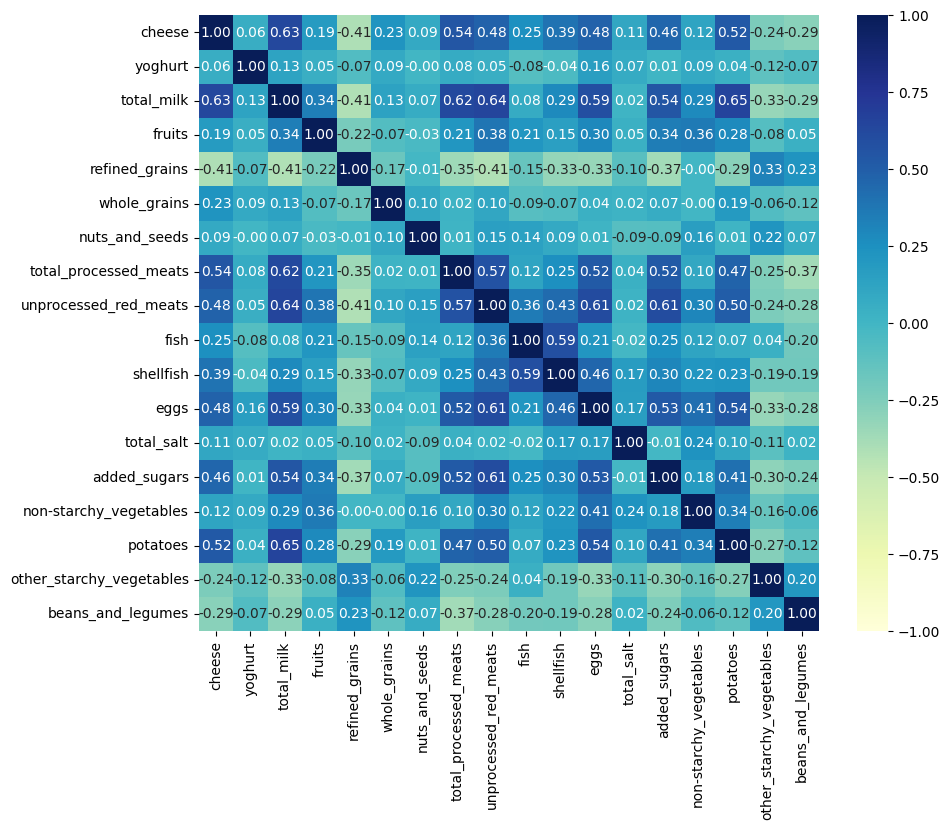

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(df[colums_to_sum].corr(), annot=True, center=0, fmt=".2f" , vmin = -1, vmax = 1 , cmap='YlGnBu')

## Histograma de cada coluna de alimento

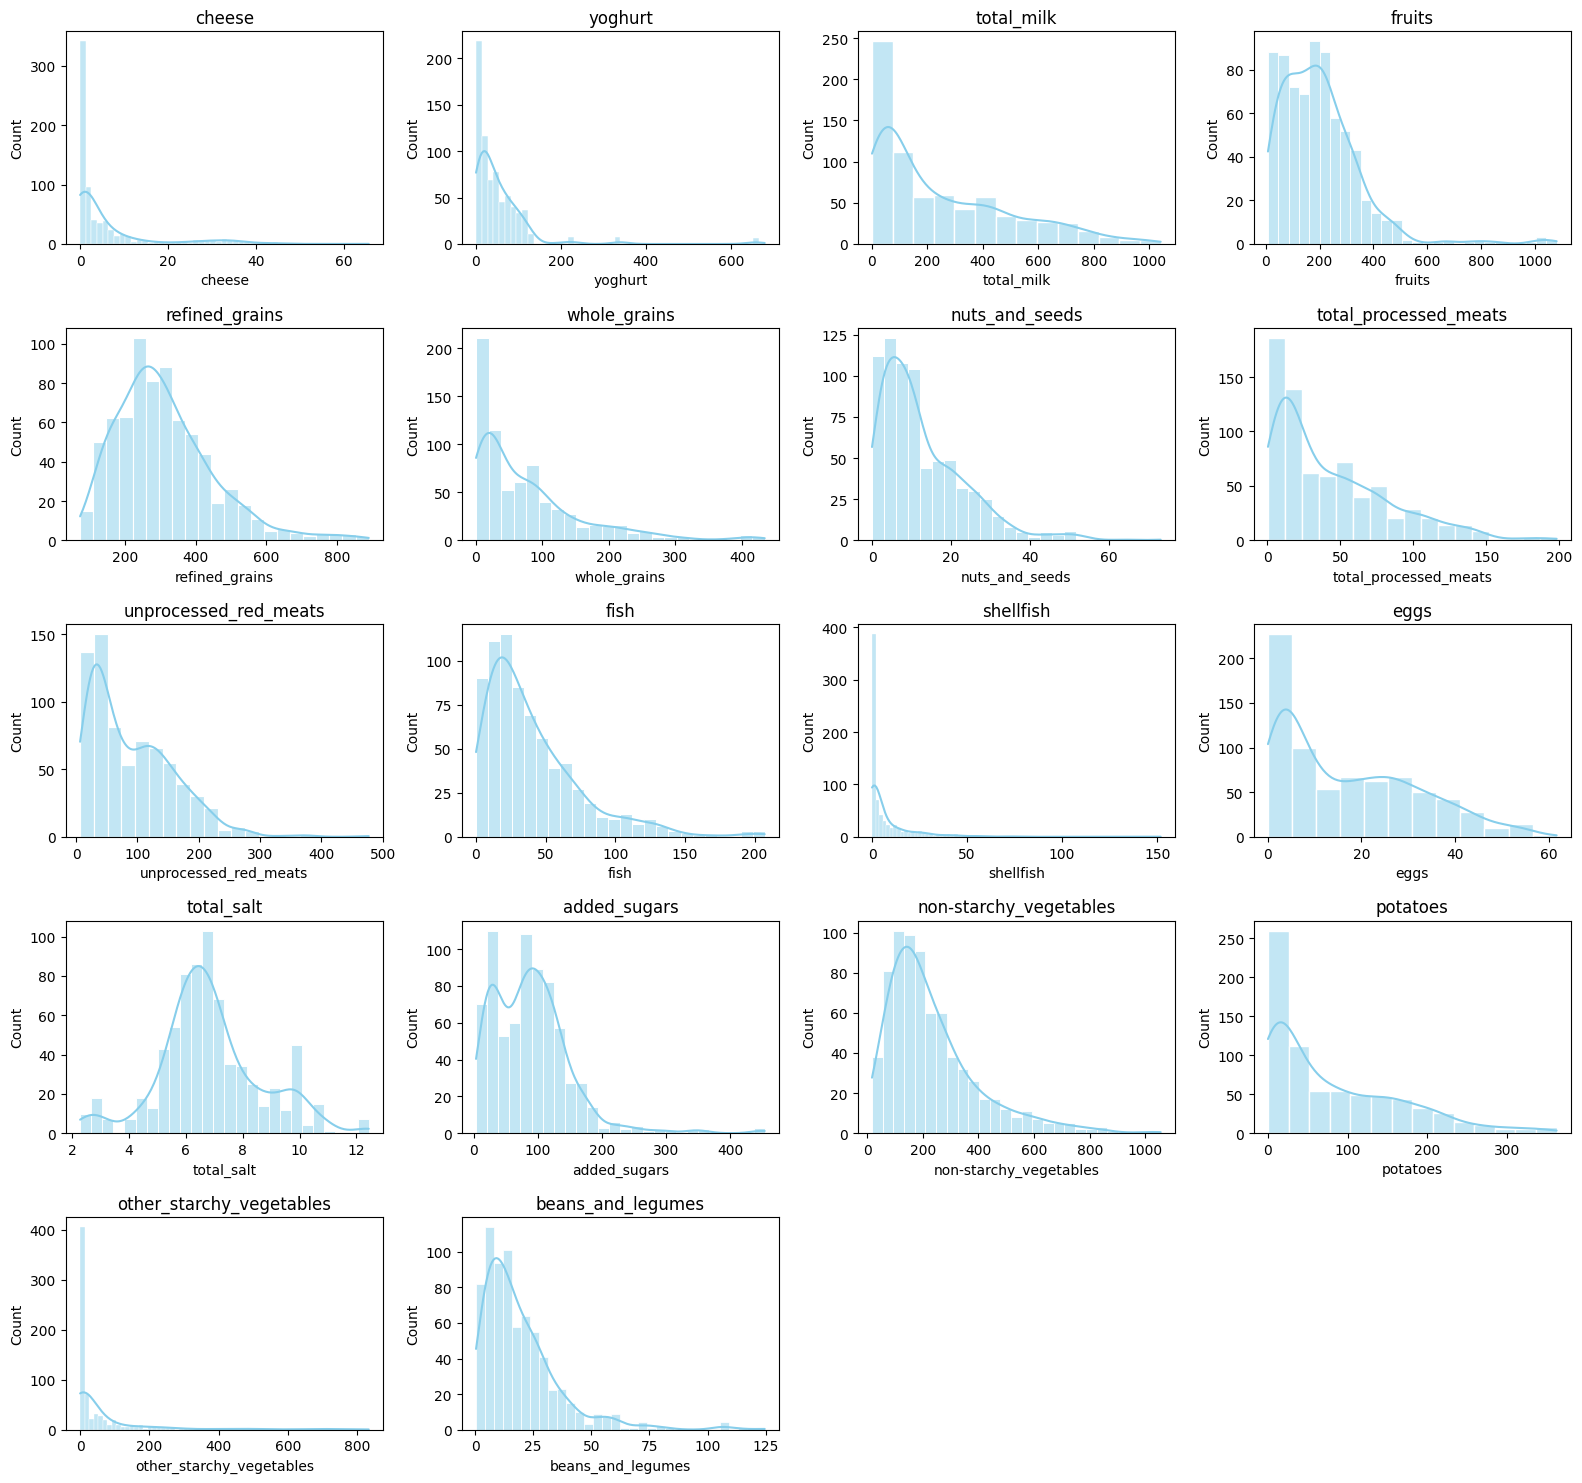

In [26]:
histplot_gen(df, colums_to_sum, cols_per_row=4)

## Normalização

In [27]:
#Normalizando a feature 'index_risk_country'

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df[['index_risk_country']])
X_scaled = scaler.fit_transform(df[colums_to_sum])

# Testando parâmetros para os Modelos

## Modelos

### K-means

In [28]:
# KMEANS

crossval_results_kmeans = []

for k in range(3, 11):
    for init in ['k-means++', 'random']:
        kmeans = KMeans(n_clusters=k, init=init, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        crossval_results_kmeans.append({
            'model': 'KMeans',
            'n_clusters': k,
            'param': f'init={init}',
            'silhouette': silhouette,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score
        })

### Dbscan

In [29]:
# DBSCAN

crossval_results_dbscan = []

for eps in [0.3, 0.5, 0.7]:
    for min_samples in [3, 5, 7]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, labels)
            ch_score = calinski_harabasz_score(X_scaled, labels)
            db_score = davies_bouldin_score(X_scaled, labels)
            crossval_results_dbscan.append({
                'model': 'DBSCAN',
                'n_clusters': n_clusters,
                'param': f'eps={eps}, min_samples={min_samples}',
                'silhouette': silhouette,
                'calinski_harabasz': ch_score,
                'davies_bouldin': db_score
            })

### Agglomerative

In [30]:
# AGGLOMERATIVE

crossval_results_agglo = []

for k in range(3, 11):
    for link in ['ward', 'average', 'complete']:
        if link == 'ward':
            agglo = AgglomerativeClustering(n_clusters=k, linkage=link)
        else:
            agglo = AgglomerativeClustering(n_clusters=k, linkage=link, metric='euclidean')
        labels = agglo.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        crossval_results_agglo.append({
            'model': 'Agglomerative',
            'n_clusters': k,
            'param': f'linkage={link}',
            'silhouette': silhouette,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score
        })

## Comparação de cada Modelo

In [31]:
results_df = pd.DataFrame(crossval_results_kmeans + crossval_results_agglo + crossval_results_dbscan)
results_df

,model,n_clusters,param,silhouette,calinski_harabasz,davies_bouldin
0,KMeans,3,init=k-means++,0.156462,156.532687,2.134546
1,KMeans,3,init=random,0.156462,156.532687,2.134546
2,KMeans,4,init=k-means++,0.151542,129.050351,2.101880
3,KMeans,4,init=random,0.146122,128.592011,2.122494
4,KMeans,5,init=k-means++,0.155846,114.098260,1.978005
5,KMeans,5,init=random,0.150873,111.663325,1.976949
6,KMeans,6,init=k-means++,0.160337,104.796962,1.793838
7,KMeans,6,init=random,0.164489,103.170051,1.924090
8,KMeans,7,init=k-means++,0.171512,98.799265,1.677276
9,KMeans,7,init=random,0.165970,96.217099,1.783347


### Comparação Scatter Silhouette x Davies-Bouldin

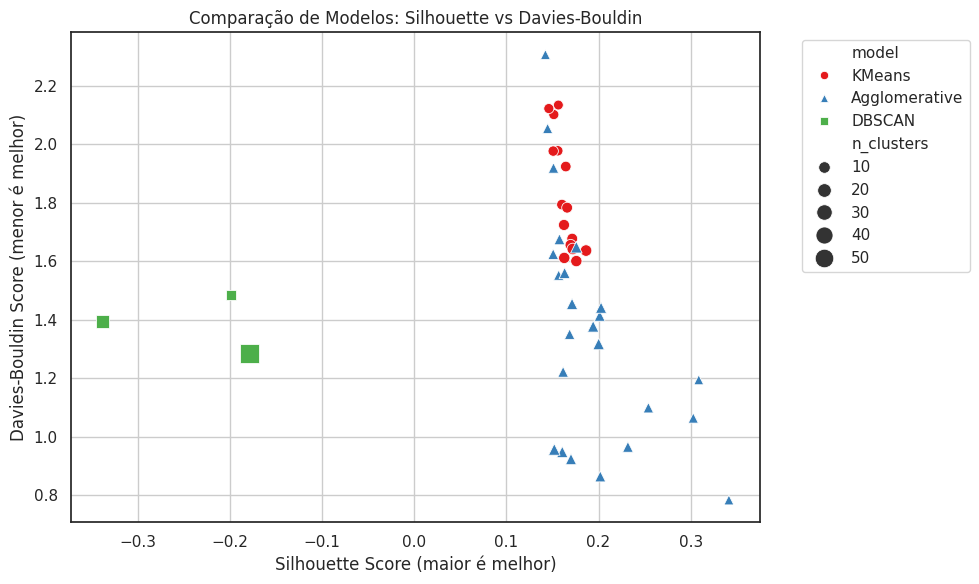

In [32]:
results_df = pd.DataFrame(crossval_results_kmeans + crossval_results_agglo + crossval_results_dbscan)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x='silhouette',
    y='davies_bouldin',
    hue='model',
    style='model',
    markers={'KMeans': 'o', 'Agglomerative': '^', 'DBSCAN': 's'},
    size='n_clusters',
    sizes=(50, 200),
    palette='Set1'
)

plt.title('Comparação de Modelos: Silhouette vs Davies-Bouldin')
plt.xlabel('Silhouette Score (maior é melhor)')
plt.ylabel('Davies-Bouldin Score (menor é melhor)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* Pontos no canto superior esquerdo são os piores:
Silhouette Score baixo (clusters mal definidos e sobrepostos) e Davies-Bouldin alto (grande sobreposição entre clusters e baixa separação).

* Pontos no canto inferior direito são os melhores:
Silhouette Score alto (clusters bem separados e coesos) e Davies-Bouldin baixo (menor sobreposição e maior separação entre clusters).

* O tamanho do ponto indica o número de clusters encontrados:
Para KMeans e Agglomerative, é o número de clusters especificado no modelo. Para DBSCAN, é o número de clusters identificados (excluindo pontos marcados como ruído).

### Comparação Calinski-Harabasz x Silhouette

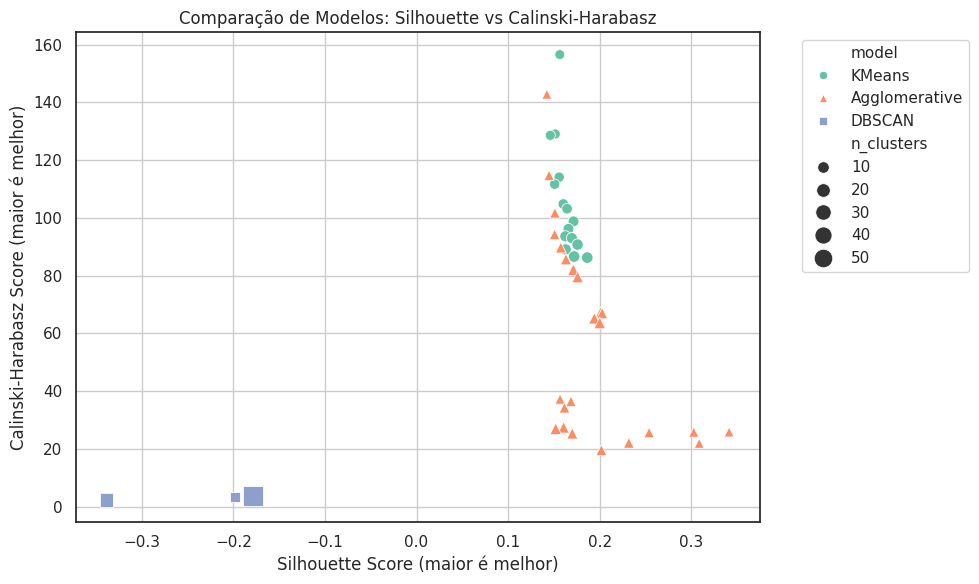

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x='silhouette',
    y='calinski_harabasz',
    hue='model',
    style='model',
    markers={'KMeans': 'o', 'Agglomerative': '^', 'DBSCAN': 's'},
    size='n_clusters',
    sizes=(50, 200),
    palette='Set2'
)

plt.title('Comparação de Modelos: Silhouette vs Calinski-Harabasz')
plt.xlabel('Silhouette Score (maior é melhor)')
plt.ylabel('Calinski-Harabasz Score (maior é melhor)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


* Pontos no canto inferior esquerdo são os piores:
Silhouette Score baixo (clusters pouco coesos e mal separados) e Calinski-Harabasz baixo (clusters pouco compactos e com pouca separação entre eles).

* Pontos no canto superior direito são os melhores:
Silhouette Score alto (clusters bem separados e coesos) e Calinski-Harabasz alto (clusters compactos e bem distintos uns dos outros).

* O tamanho do ponto indica o número de clusters encontrados:
Para KMeans e Agglomerative, é o número de clusters definido no modelo. Para DBSCAN, é o número de clusters identificados (excluindo ruído).

## Visualizações

### Visualizando os melhores por Silhouette Score

In [34]:
results_df.sort_values(by='silhouette', ascending=False).head(10)

,model,n_clusters,param,silhouette,calinski_harabasz,davies_bouldin
17,Agglomerative,3,linkage=average,0.341455,25.851530,0.783033
18,Agglomerative,3,linkage=complete,0.308754,21.942863,1.194193
20,Agglomerative,4,linkage=average,0.302812,25.823872,1.063371
23,Agglomerative,5,linkage=average,0.254114,25.667358,1.098624
26,Agglomerative,6,linkage=average,0.231894,22.099312,0.964547
33,Agglomerative,8,linkage=complete,0.202782,66.972049,1.440997
29,Agglomerative,7,linkage=average,0.201934,19.576331,0.863509
30,Agglomerative,7,linkage=complete,0.201296,67.389819,1.413263
39,Agglomerative,10,linkage=complete,0.200164,63.628564,1.316919
36,Agglomerative,9,linkage=complete,0.194190,65.210992,1.376898


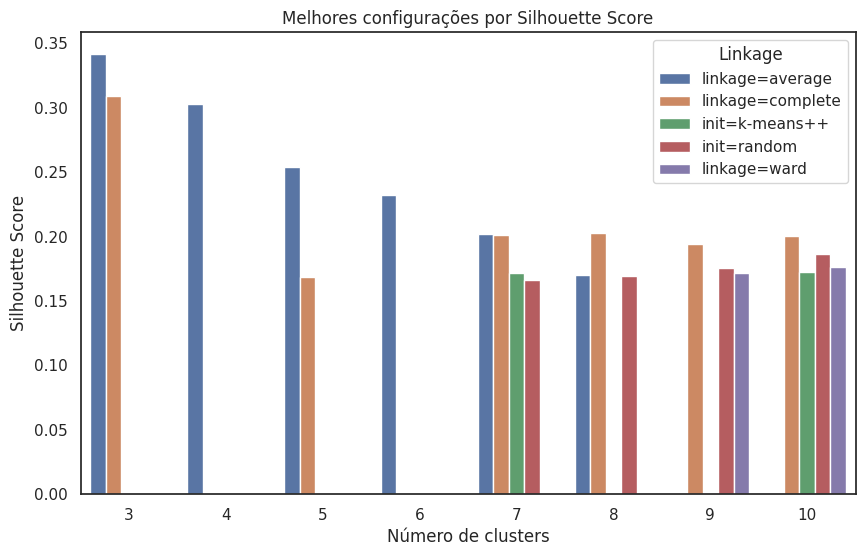

In [61]:
#plot
top_results = results_df.sort_values(by='silhouette', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_results, x='n_clusters', y='silhouette', hue='param')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Melhores configurações por Silhouette Score')
plt.legend(title='Linkage')
plt.show()

### Visualizando os melhores por Calinski-Harabasz

In [35]:
# Visualizando os melhores por Calinski-Harabasz
results_df.sort_values(by='calinski_harabasz', ascending=False).head(10)

,model,n_clusters,param,silhouette,calinski_harabasz,davies_bouldin
0,KMeans,3,init=k-means++,0.156462,156.532687,2.134546
1,KMeans,3,init=random,0.156462,156.532687,2.134546
16,Agglomerative,3,linkage=ward,0.142404,142.821271,2.307123
2,KMeans,4,init=k-means++,0.151542,129.050351,2.101880
3,KMeans,4,init=random,0.146122,128.592011,2.122494
19,Agglomerative,4,linkage=ward,0.144808,114.728237,2.054333
4,KMeans,5,init=k-means++,0.155846,114.098260,1.978005
5,KMeans,5,init=random,0.150873,111.663325,1.976949
6,KMeans,6,init=k-means++,0.160337,104.796962,1.793838
7,KMeans,6,init=random,0.164489,103.170051,1.924090


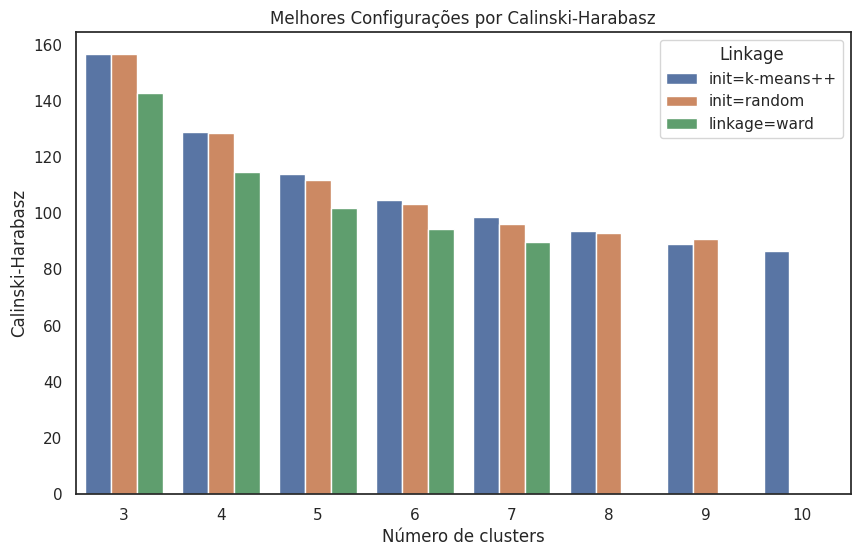

In [59]:
#plot
top_results = results_df.sort_values(by='calinski_harabasz', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_results, x='n_clusters', y='calinski_harabasz', hue='param')
plt.xlabel('Número de clusters')
plt.ylabel('Calinski-Harabasz')
plt.title('Melhores Configurações por Calinski-Harabasz')
plt.legend(title='Linkage')
plt.show()

### Visualizando os melhores por Davies-Bouldin

In [36]:
# Visualizando os melhores por Davies-Bouldin
results_df.sort_values(by='davies_bouldin', ascending=False).head(10)

,model,n_clusters,param,silhouette,calinski_harabasz,davies_bouldin
16,Agglomerative,3,linkage=ward,0.142404,142.821271,2.307123
0,KMeans,3,init=k-means++,0.156462,156.532687,2.134546
1,KMeans,3,init=random,0.156462,156.532687,2.134546
3,KMeans,4,init=random,0.146122,128.592011,2.122494
2,KMeans,4,init=k-means++,0.151542,129.050351,2.101880
19,Agglomerative,4,linkage=ward,0.144808,114.728237,2.054333
4,KMeans,5,init=k-means++,0.155846,114.098260,1.978005
5,KMeans,5,init=random,0.150873,111.663325,1.976949
7,KMeans,6,init=random,0.164489,103.170051,1.924090
22,Agglomerative,5,linkage=ward,0.151172,101.735058,1.919061


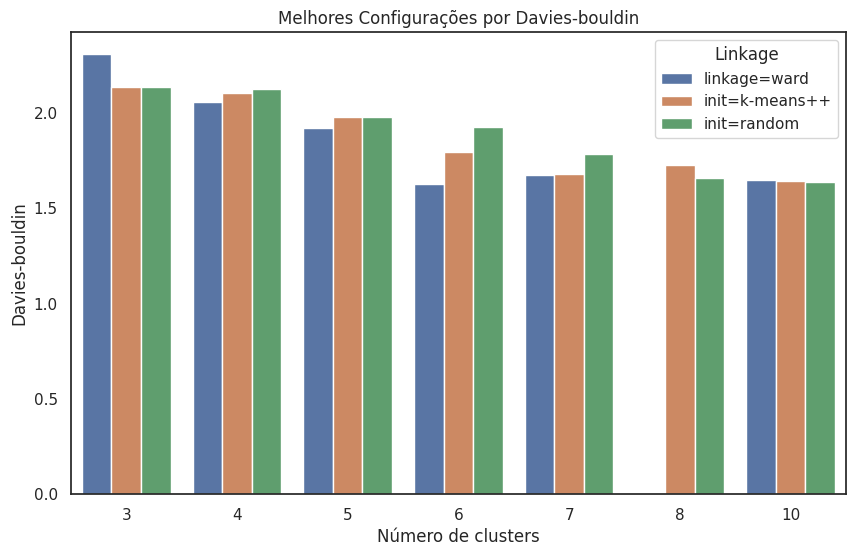

In [58]:
#plot
top_results = results_df.sort_values(by='davies_bouldin', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_results, x='n_clusters', y='davies_bouldin', hue='param')
plt.xlabel('Número de clusters')
plt.ylabel('Davies-bouldin')
plt.title('Melhores Configurações por Davies-bouldin')
plt.legend(title='Linkage')
plt.show()

## Melhores combinações de parâmetros

A tabela abaixo apresenta as 5 melhores combinações de modelo e parâmetros testados, ordenadas pelo Silhouette Score.

* O Silhouette Score é uma métrica que avalia a coesão e a separação dos clusters — quanto maior, melhor a qualidade dos agrupamentos.

Além do Silhouette Score, são exibidas as métricas Calinski-Harabasz e Davies-Bouldin, que complementam a avaliação:

* Calinski-Harabasz Score: quanto maior, melhor, pois indica clusters mais compactos e bem separados.

* Davies-Bouldin Score: quanto menor, melhor, pois indica menor sobreposição entre clusters.

Essa tabela permite identificar rapidamente quais modelos e configurações produziram os agrupamentos mais consistentes e robustos no contexto do problema.

In [37]:
top5 = results_df.sort_values(by='silhouette', ascending=False).head(5)
display(top5)


,model,n_clusters,param,silhouette,calinski_harabasz,davies_bouldin
17,Agglomerative,3,linkage=average,0.341455,25.851530,0.783033
18,Agglomerative,3,linkage=complete,0.308754,21.942863,1.194193
20,Agglomerative,4,linkage=average,0.302812,25.823872,1.063371
23,Agglomerative,5,linkage=average,0.254114,25.667358,1.098624
26,Agglomerative,6,linkage=average,0.231894,22.099312,0.964547


Como o Agglomerative Clusters teve os melhores resultados, utilizaremos ele para as nossas análises.

## Análise do dataset com Agglomerative Network Otimizado

In [38]:
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_labels, agglo_cv = run_model(agglo, X_scaled, [])

### Cross-validation

In [39]:
print(agglo_cv)

[(0.34145541199008456, 25.851530071546392, 0.7830330215636031)]


### PCA

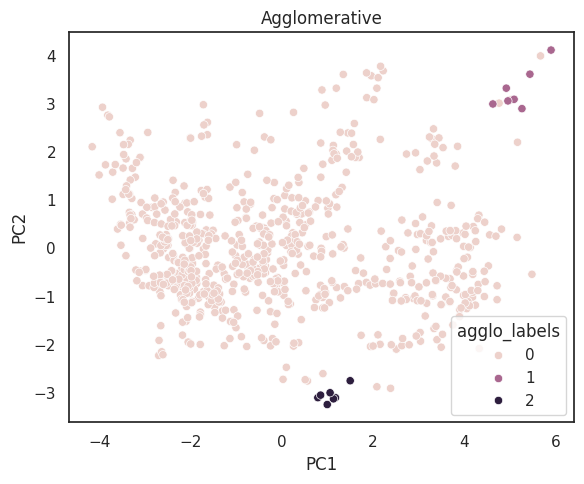

In [40]:
agglo_column = 'agglo_labels'
agglo_title = 'Agglomerative'

df[agglo_column] = agglo_labels

agglo_loading_df, agglo_explained_var = pca_gen(X_scaled=X_scaled, df=df,
                                                  column=[agglo_column], title=[agglo_title],
                                                  feature_names=colums_to_sum, return_loadings=True)

### Análise dos resultados do PCA

In [41]:
# Alimentos mais influentes na PC1
agglo_loading_df['abs_PC1'] = agglo_loading_df['PC1'].abs()
mais_influentes_PC1 = agglo_loading_df.sort_values('abs_PC1', ascending=False)
print(f"Alimentos mais influentes de PC1:\n{mais_influentes_PC1.head(3)}\n")

# Alimentos mais influentes na PC2
agglo_loading_df['abs_PC2'] = agglo_loading_df['PC2'].abs()
mais_influentes_PC2 = agglo_loading_df.sort_values('abs_PC2', ascending=False)
print(f"Alimentos mais influentes de PC2:\n{mais_influentes_PC2.head(3)}\n")

Alimentos mais influentes de PC1:
                            PC1       PC2   abs_PC1
total_milk             0.348858 -0.157880  0.348858
unprocessed_red_meats  0.345184  0.114626  0.345184
eggs                   0.335276  0.014382  0.335276

Alimentos mais influentes de PC2:
                   PC1       PC2   abs_PC1   abs_PC2
fish          0.151287  0.563461  0.151287  0.563461
shellfish     0.234578  0.408981  0.234578  0.408981
whole_grains  0.063172 -0.308563  0.063172  0.308563



In [42]:
for idx in mais_influentes_PC1.index[:3]:
    print(f"--- Alimento: {idx} ---")
    print(f"Média de microplásticos encontrada no alimento: {df[idx].mean()}")
    print(f"Desvio padrão de microplásticos encontrada no alimento: {df[idx].std()}")
    print(f"Valor mínimo de microplásticos encontrada no alimento: {df[idx].min()}")
    print(f"Valor máximo de microplásticos encontrada no alimento: {df[idx].max()}\n")

--- Alimento: total_milk ---
Média de microplásticos encontrada no alimento: 250.65522272055736
Desvio padrão de microplásticos encontrada no alimento: 243.25066960623946
Valor mínimo de microplásticos encontrada no alimento: 1.808219178
Valor máximo de microplásticos encontrada no alimento: 1040.931507

--- Alimento: unprocessed_red_meats ---
Média de microplásticos encontrada no alimento: 90.3267266039668
Desvio padrão de microplásticos encontrada no alimento: 67.64665473283996
Valor mínimo de microplásticos encontrada no alimento: 6.583087143
Valor máximo de microplásticos encontrada no alimento: 477.3013884

--- Alimento: eggs ---
Média de microplásticos encontrada no alimento: 17.184713617167358
Desvio padrão de microplásticos encontrada no alimento: 14.584194708212422
Valor mínimo de microplásticos encontrada no alimento: 0.02739726
Valor máximo de microplásticos encontrada no alimento: 61.69863014



In [43]:
for idx in mais_influentes_PC2.index[:3]:
    print(f"--- Alimento: {idx} ---")
    print(f"Média de microplásticos encontrada no alimento: {df[idx].mean()}")
    print(f"Desvio padrão de microplásticos encontrada no alimento: {df[idx].std()}")
    print(f"Valor mínimo de microplásticos encontrada no alimento: {df[idx].min()}")
    print(f"Valor máximo de microplásticos encontrada no alimento: {df[idx].max()}\n")

--- Alimento: fish ---
Média de microplásticos encontrada no alimento: 40.367153603004155
Desvio padrão de microplásticos encontrada no alimento: 34.83591763802595
Valor mínimo de microplásticos encontrada no alimento: 0.054794521
Valor máximo de microplásticos encontrada no alimento: 207.3150685

--- Alimento: shellfish ---
Média de microplásticos encontrada no alimento: 7.415297751051175
Desvio padrão de microplásticos encontrada no alimento: 13.695479417119778
Valor mínimo de microplásticos encontrada no alimento: 0.0
Valor máximo de microplásticos encontrada no alimento: 151.8630137

--- Alimento: whole_grains ---
Média de microplásticos encontrada no alimento: 76.09072000565007
Desvio padrão de microplásticos encontrada no alimento: 81.57888059879556
Valor mínimo de microplásticos encontrada no alimento: 0.158798163
Valor máximo de microplásticos encontrada no alimento: 434.1211239



In [44]:
# agglo_explained_var
print(f"Porcentagem dos dados explicada por PC1: {agglo_explained_var[0]:.2f}")
print(f"Porcentagem dos dados explicada por PC2: {agglo_explained_var[1]:.2f}")

Porcentagem dos dados explicada por PC1: 0.31
Porcentagem dos dados explicada por PC2: 0.09


### Gráfico do PCA

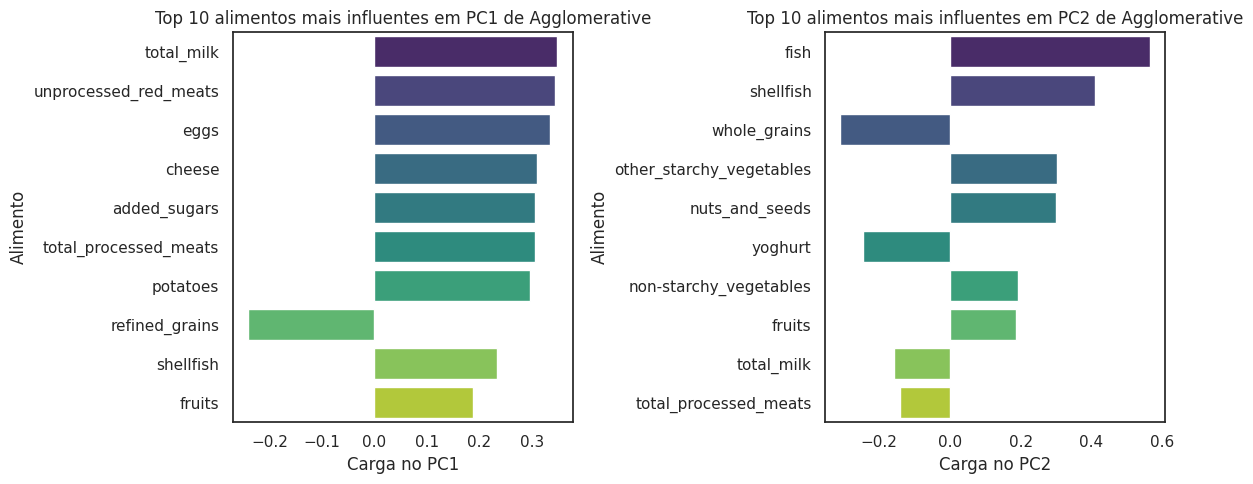

In [45]:
plot_pca_loadings_barras(agglo_loading_df, component=['PC1', 'PC2'], top_n=10, title=agglo_title)

### Boxplot

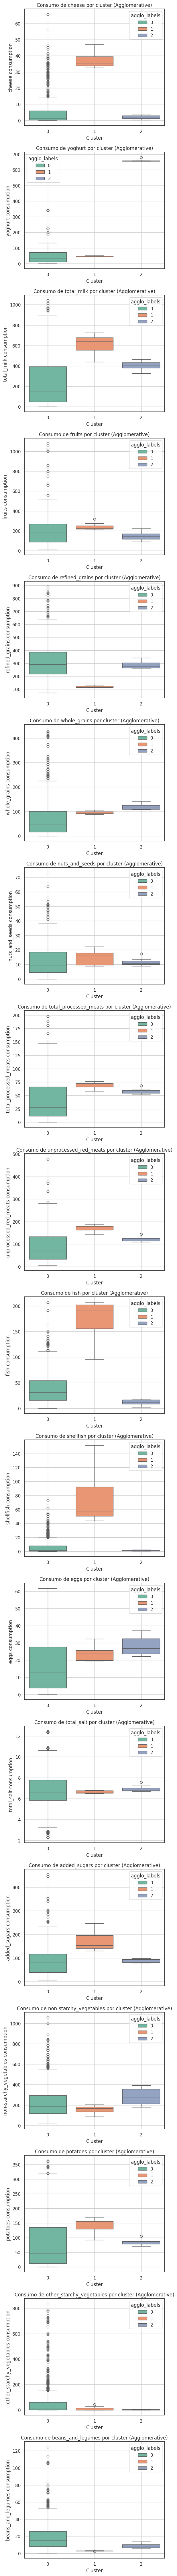

In [46]:
# boxplot_gen(df=df, column=[agglo_column], title=[agglo_title])
boxplot_gen(df, alimentos=list(colums_to_sum), column=[agglo_column], title=[agglo_title])

### Heatmap (média de consumo de microplásticos)

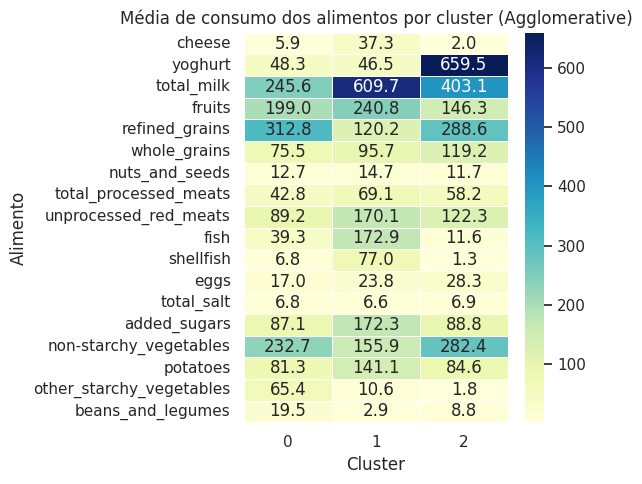

In [47]:
# heatmap_gen(df=df)
heatmap_gen(df, alimentos=list(colums_to_sum), column=[agglo_column], title=[agglo_title])

### Importância Relativa

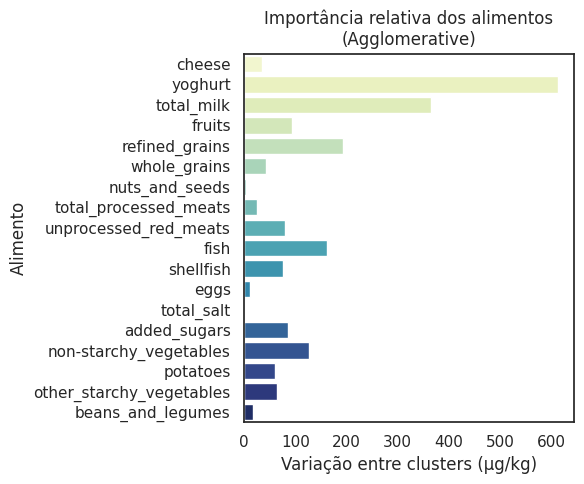

In [48]:
relative_variation(df, alimentos=list(colums_to_sum), column=[agglo_column], title=[agglo_title])

## Análise dos Clusters

In [49]:
df.head()

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,...,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg,agglo_labels,PC1,PC2
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,...,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108,0,-2.478841,-0.186894
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,...,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197,0,-3.341030,0.750993
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,...,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927,0,-2.440871,-0.681854
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,...,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905,0,-2.205279,-0.783781
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,...,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458,0,-3.104620,1.886482


In [50]:
clusters = sorted(df[agglo_column].unique())

for c in clusters:
    print(f"\n--- Cluster {c} ---")
    top_n = 5
    sub = df[df[agglo_column] == c]

    # 1. Média e desvio padrão da concentração total
    media = sub[colums_to_sum].mean().mean()

    desvio = sub[colums_to_sum].std().std()
    print(f"Média de microplásticos (μg/kg): {media:.2f}")
    print(f"Desvio padrão: {desvio:.2f}")

    # 2. Alimentos com maior quantidade de microplásticos
    # Para cada coluna, pega o maior valor dentro dela
    max_por_coluna = sub[colums_to_sum].mean()

    # Ordena os valores decrescentemente e pega os top_n
    top_colunas = max_por_coluna.sort_values(ascending=False).head(top_n)
    print(f"\nTop {top_n} alimentos com maior quantidade de microplásticos média:")
    print(top_colunas)

    # # 3. Soma total do consumo de cada alimento nesse cluster
    # total_consumo = sub[colums_to_sum].sum().sort_values(ascending=False)

    # print(f"\nTop {top_n} alimentos mais consumidos:")
    # print(total_consumo.head(top_n))

    # 4. Países com maior consumo de microplásticos por cluster
    paises = sub.sort_values(by='total_ug_per_kg', ascending=False)['country']
    print(f"\nTop {top_n} países com maior consumo de microplásticos:")
    print(paises.unique()[:top_n])

    # 5. Países com menor consumo de microplásticos por cluster
    paises = sub.sort_values(by='total_ug_per_kg', ascending=True)['country']
    print(f"\nTop {top_n} países com menor consumo de microplásticos:")
    print(paises.unique()[:top_n])


--- Cluster 0 ---
Média de microplásticos (μg/kg): 88.21
Desvio padrão: 68.03

Top 5 alimentos com maior quantidade de microplásticos média:
refined_grains            312.834164
total_milk                245.604653
non-starchy_vegetables    232.668122
fruits                    198.996851
unprocessed_red_meats      89.223535
dtype: float64

Top 5 países com maior consumo de microplásticos:
['Barbados' 'Greece' 'Albania' 'Dominica' 'Montenegro']

Top 5 países com menor consumo de microplásticos:
['Bangladesh' 'Myanmar' 'Cambodia' 'Laos' 'Vietnam']

--- Cluster 1 ---
Média de microplásticos (μg/kg): 120.39
Desvio padrão: 25.38

Top 5 alimentos com maior quantidade de microplásticos média:
total_milk               609.737769
fruits                   240.771037
fish                     172.861057
added_sugars             172.270059
unprocessed_red_meats    170.111146
dtype: float64

Top 5 países com maior consumo de microplásticos:
['Iceland']

Top 5 países com menor consumo de microplásti